# Project Name and Description

## Contents
1. Frame the problem  and look at the big picture
2. Get the data
3. Explore and visualize the data to gain insights
4. Prepare the data to better expose the underlying patterns to machine learning algorithm
5. Explore many modesl; Select a model and train it
6. Fine-tune the model
7. Present your solution
8. Launch, monitor and maintain your system



# 1. Frame the problem

TODO

In [155]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from scipy.stats import kruskal

In [21]:
# Sklearn imports
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

In [3]:
# Custom-made utilities
from src.data_retrieval import fetch_data
from src.utilities import save_fig

In [4]:
# Some plotting settings
plt.rc('font', size=11)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

# 2. Getting the data

In [5]:
# Load data
df_full = df = fetch_data()
target = 'median_house_value'  # the name of the target feature
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df[df['total_bedrooms'].isnull()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
182,-118.27,34.04,13.0,1784.0,NaN,2158.0,682.0,1.7038,118100.0,<1H OCEAN
327,-117.65,34.04,15.0,3393.0,NaN,2039.0,611.0,3.9336,151000.0,INLAND
366,-122.50,37.75,44.0,1819.0,NaN,1137.0,354.0,3.4919,271800.0,NEAR OCEAN
477,-117.99,34.14,30.0,2346.0,NaN,1988.0,474.0,2.5625,153000.0,INLAND
495,-114.59,34.83,41.0,812.0,NaN,375.0,158.0,1.7083,48500.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
19880,-118.23,33.94,36.0,1110.0,NaN,1417.0,302.0,2.3333,92100.0,<1H OCEAN
19952,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
20088,-119.73,36.83,8.0,3602.0,NaN,1959.0,580.0,5.3478,138800.0,INLAND
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN


In [7]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


'images/distributions of numerical variables.png'

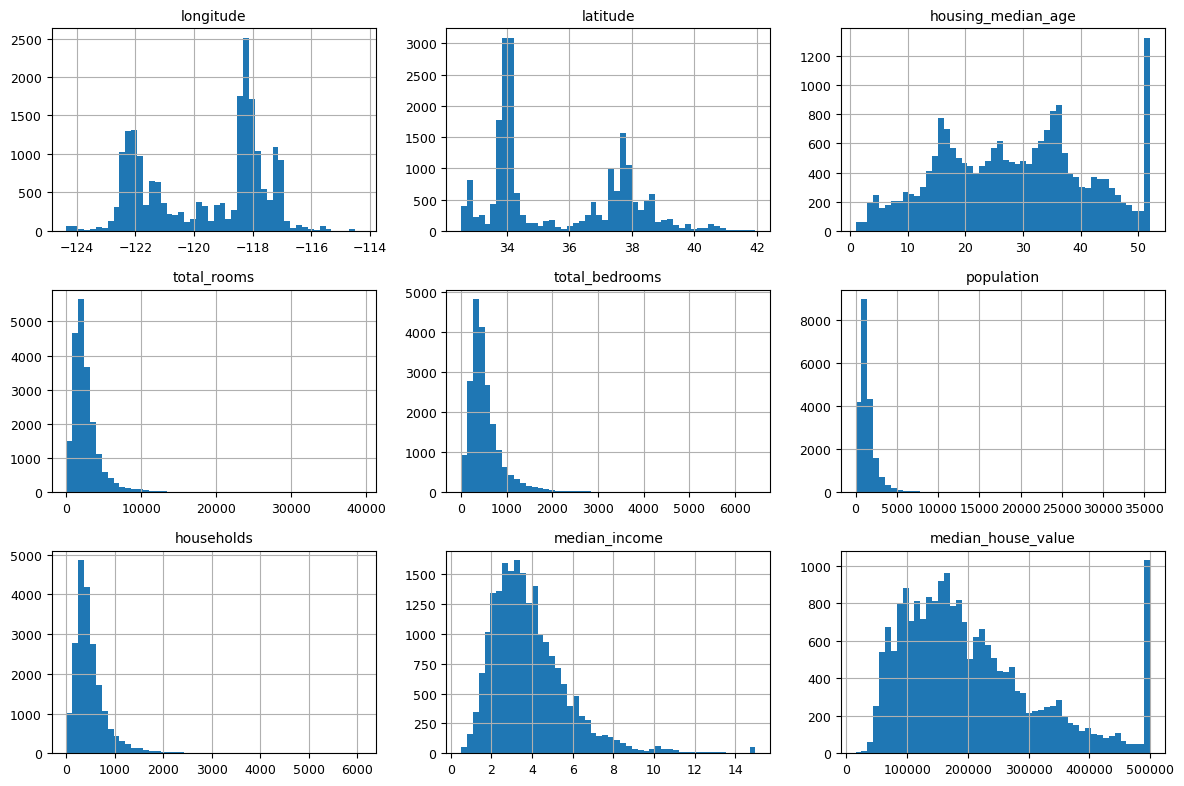

In [9]:
df.hist(bins=50, figsize=(12, 8))
save_fig("distributions of numerical variables")

## Train Test Split
Domain knowledge: because `median income` is important in predicting the target, the train-test split must be stratified on that feature.

In [10]:
# Make income category (temporary)
income_cat = pd.cut(df['median_income'],
                    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                    right=False,
                    labels=[1, 2, 3, 4, 5])

'images/income categories.png'

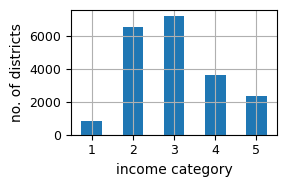

In [11]:
# Vizualise the categories
income_cat.value_counts().sort_index().plot.bar(rot=0, grid=True, figsize=(3,2))
plt.xlabel("income category")
plt.ylabel("no. of districts")
save_fig("income categories")

## Stratified split demo


In [12]:
# Generate 7 different stratified splits
splitter = StratifiedShuffleSplit(n_splits=7, test_size=0.2, random_state=42)

stratified_data_splits = []

for train_idx, test_idx in splitter.split(df_full, income_cat):
    train_set, test_set = df_full.iloc[train_idx], df_full.iloc[test_idx]
    stratified_data_splits.append([train_set, test_set])

print(len(stratified_data_splits), stratified_data_splits[0], sep="\n\n")

7

[       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17449    -122.29     38.00                16.0       4986.0          1081.0   
17064    -118.01     33.86                29.0       2307.0           452.0   
17341    -121.56     38.58                32.0       2070.0           561.0   
7160     -121.94     38.37                17.0       7973.0          1591.0   
20462    -118.10     34.08                21.0       1349.0           352.0   
...          ...       ...                 ...          ...             ...   
14471    -117.11     32.69                37.0       2395.0           627.0   
20081    -117.20     33.70                23.0       6323.0          1196.0   
18541    -122.14     40.07                31.0       2053.0           465.0   
19715    -118.36     33.94                39.0       1390.0           410.0   
3724     -117.23     33.96                 5.0       9179.0          1361.0   

       population  households  median_income  m

## Actual split

In [13]:
# Stratified splits
train_set, test_set = train_test_split(df_full, test_size=0.2, stratify=income_cat, random_state=42)

# 3. Explore the data

In [14]:
# 1. Put away the test set
test_set.to_csv("data/test_set.csv")

# 2. Also, save the train set
train_set.to_csv("data/train_set.csv")

# 2. Make an exploration subset
df = df_exploration = housing = train_set.copy()  # full because len(train_set) is small

'images/California.png'

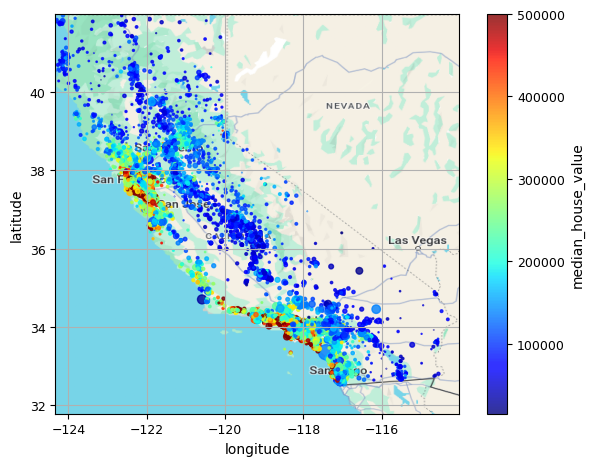

In [15]:
# Visualize on the map
extent = [-124.34,-114.02, 31.78,41.99]  # photo extent

df.plot(kind='scatter', x='longitude', y='latitude', grid=True,
        s=df['population'] / 300, c='median_house_value', cmap='jet', colorbar=True, alpha=0.8,
        legend=True, sharex=True)
plt.axis(extent)

pn = plt.imread("images/[-124.34,-114.02,31.78,41.99].png")  # (553, 444, 4)
plt.imshow(pn, extent=extent)
save_fig("California")

In [55]:
# Experiment with DBSCAN
dbscan = DBSCAN(eps=0.25, min_samples=150, metric='euclidean')
df['cluster'] = dbscan.fit_predict(df[['longitude', 'latitude']])
df['cluster'].value_counts()

cluster
 1    7148
 0    3802
-1    2113
 2    1360
 4    1271
 3     610
 5     208
Name: count, dtype: int64

'images/DBSCAN.png'

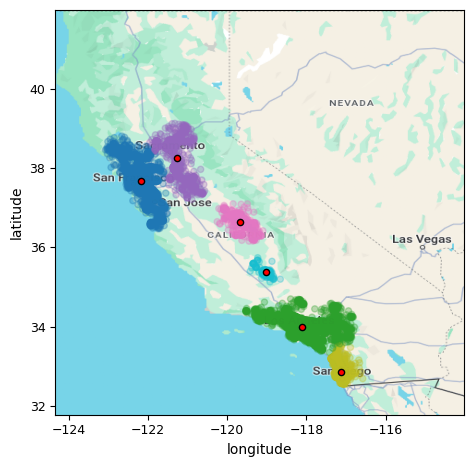

In [144]:
# Visualize the DBSCAN clusters
ax = plt.axes()

pn = plt.imread("images/[-124.34,-114.02,31.78,41.99].png")  # (553, 444, 4)
extent = [-124.34,-114.02, 31.78,41.99]  # photo extent
ax.imshow(pn, extent=extent)
plt.axis(extent)

# Plot the clusters
df[df['cluster'] != -1].plot(kind='scatter', x='longitude', y='latitude', c='cluster', 
                                            alpha=0.3, cmap='tab10', colorbar=False, ax=ax)

# Draw the cluster centroids
df_centroids = df[['longitude', 'latitude', 'cluster']].groupby('cluster').mean().drop(-1, axis=0).sort_index()
df_centroids.plot(kind='scatter', x='longitude', y='latitude', c='red', edgecolor='k', ax=ax)

save_fig("DBSCAN")


In [80]:
# Add a new feature: distance from the respective centroid

def func(row: pd.Series):
    if row['cluster'] == -1:
        return np.nan
    return ((row[['longitude', 'latitude']] - df_centroids.loc[row['cluster']])**2).sum() ** (1/2)

df["distance_from_centroid"] = df.apply(func, axis=1)
df.head(10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,cluster,distance_from_centroid
17449,-122.29,38.00,16.0,4986.0,1081.0,2805.0,1016.0,4.0250,173200.0,NEAR BAY,0,0.341508
17064,-118.01,33.86,29.0,2307.0,452.0,1218.0,402.0,3.4306,194200.0,<1H OCEAN,1,0.160812
17341,-121.56,38.58,32.0,2070.0,561.0,2046.0,523.0,1.9426,82300.0,INLAND,2,0.439921
7160,-121.94,38.37,17.0,7973.0,1591.0,2899.0,1502.0,2.8357,120100.0,INLAND,0,0.734263
20462,-118.10,34.08,21.0,1349.0,352.0,1188.0,330.0,2.5000,182100.0,<1H OCEAN,1,0.087449


In [111]:
# Kruskal-Wallis H-test for 'cluster' -> tagret
# H0: no dependence

alpha = 0.05
samples = [e[0] for e in df[['cluster', target]].groupby('cluster').agg(list).values]
res = kruskal(*samples)
pvalue = res.pvalue
print(f'p-value = {pvalue}; reject H0?: {"yes" if pvalue < alpha else "no"}')

p-value = 0.0; reject H0?: yes


Kruskal-Wallis test showed that there is a strong dependence between 'cluster' and the target feature.
We will make one-hot features out of the 'cluster' feature.

In [142]:
# Check Pearson's correlation
df['reverse_distance'] = (df['distance_from_centroid'].max() - df['distance_from_centroid']).fillna(0)
X,Y = df['reverse_distance'], df[target]

statistic, pvalue = pearsonr(X,Y)
statistic

0.23708130717633408

There is a very weak correlation between the distance from the respective centroid and the target variable.
Hence do not use this engineered feature in the model building.

In [154]:
# Compute correlations
df[df.columns[:-4]].corr()[target].sort_values(key=abs, ascending=False)

median_house_value    1.000000
median_income         0.687369
latitude             -0.142290
total_rooms           0.132973
housing_median_age    0.107244
households            0.066395
longitude            -0.049937
total_bedrooms        0.049495
population           -0.025966
Name: median_house_value, dtype: float64

'images/correlation matrix.png'

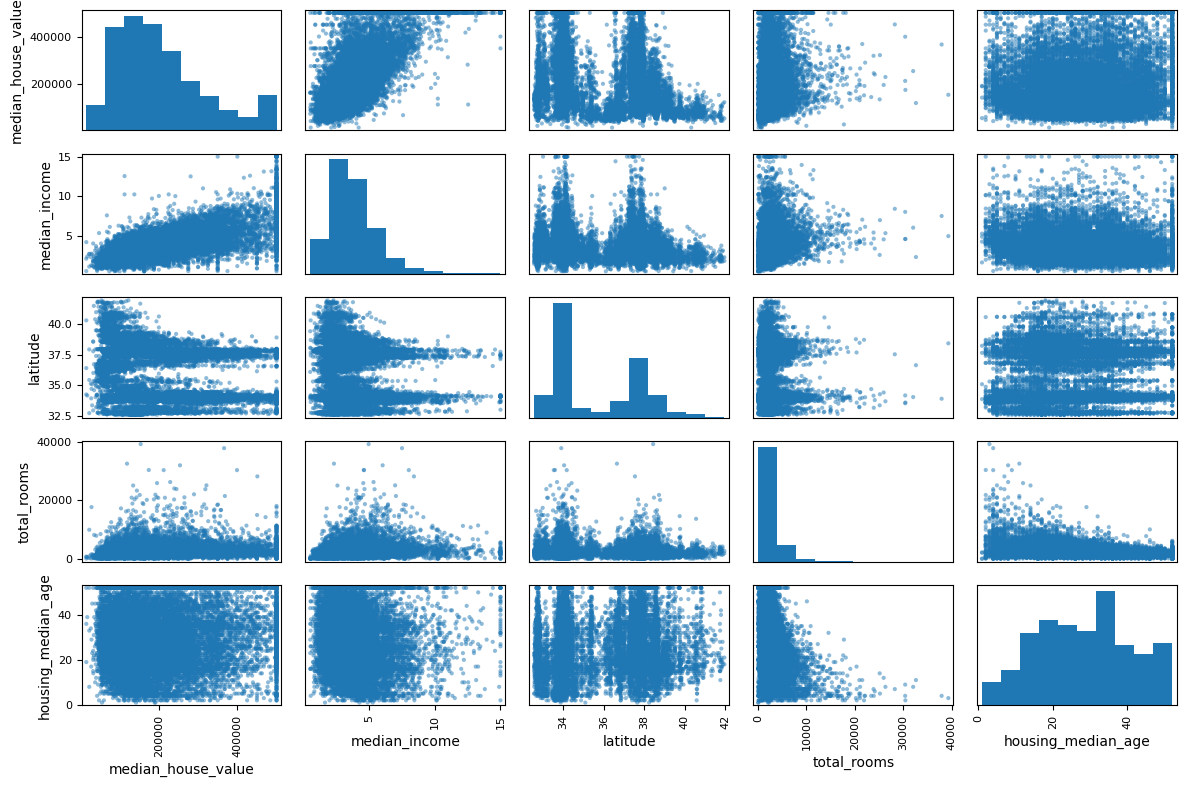

In [158]:
# Visualize the correlations
selected_features = ['median_house_value', 'median_income', 'latitude', 'total_rooms', 'housing_median_age']
scatter_matrix(df[selected_features], figsize=(12,8))
save_fig("correlation matrix")